# New York Times Front Page Sentiment Analysis

<b>"There is so much terrible news." </b>

We've all heard someone say that at one point or another. The news seems to provide a constant influx of negativity and horrible details of events transpiring in the world around us. You can't pick up the paper without reading about the latest military conflict, drug crisis, or flu pandemic. Has the news actually gotten worse over time?

In an effort to shed some light on this, we'll use the New York Times' archive API to collect the front page article headlines and synopsis for articles spanning from 1852 to 2018. We will then perform sentiment analysis on these news articles to determine whether they conveyed a positive sentiment, a negative sentiment, or a neutral sentiment. The wording that is used in the article headline and synopsis can have as much of an impact on the sentiment of it as the topic it covers.

## Environment Setup
First we will start by importing the main libraries that we will use for this task.

In [1]:
# The usual libraries
import csv
import json
import time
import nltk
import requests
import pandas as pd
import numpy as np

The New York Times requires that you register and use an API key for accessing their APIs. I've removed my API key from this, so if you wish to utilize this code you will need to register your own API key with them at their <a href="https://developer.nytimes.com/"> Developer Portal</a>.

In [3]:
api_key = "XXXXX"

## Data Mining

Let's first test the API to see what the data looks like by querying for news articles from the month of March, 1852.

In [4]:
# Perform API request using the requests library
result = requests.get("https://api.nytimes.com/svc/archive/v1/1852/4.json?api-key={}".format(api_key))

# Parse the response using the JSON library
response = json.loads(result.text)

# Display the parsed JSON keys.
response.keys()

dict_keys(['copyright', 'response'])

Let's take a look at the response key, as that will contain the fields we are looking for most likely.

In [5]:
response['response'].keys()

dict_keys(['meta', 'docs'])

Now let's take a look at one of the first documents.

In [6]:
response['response']['docs'][0]

{'abstract': "The engine Jersey City, attached to the 10 o'clock train from Newark to New-York, yesterday morning ran off the track against the rocks when about half way through the Bergen cut. The engine was greatly shattered, the front part of the first passenger car, containing the baggage room, was broken in, and the tender was thrown upon the other track, obstructing it so that the opposite train was delayed for a considerable tune.  ",
 'web_url': 'https://www.nytimes.com/1852/04/03/archives/article-5-no-title.html',
 'snippet': '',
 'lead_paragraph': '',
 'print_page': '2',
 'source': 'The New York Times',
 'multimedia': [],
 'headline': {'main': 'Article 5 -- No Title',
  'kicker': '1',
  'content_kicker': None,
  'print_headline': 'Article 5 -- No Title',
  'name': None,
  'seo': None,
  'sub': None},
 'keywords': [],
 'pub_date': '1852-04-03T05:00:00+0000',
 'document_type': 'article',
 'news_desk': 'None',
 'section_name': 'Archives',
 'byline': {'original': None, 'person': 

### Building The Dataset
Now that we know what the data looks like, we know which fields we want to capture. The get_articles function will take the array of articles received from an API query, and then extract the information that we want to keep. This function was expanded as the process went on, due to the fact that certain fields in the data were inconsistent between years.

In [8]:
def get_articles(articles):
    # Create an array to save the article dictionaries to.
    front_pages = []
    
    # Loop through each article in the response
    for article in articles['response']['docs']:
        '''
        We only want articles that were on the front page. The format used to identify this changed
        throughout the years, so we have to check for a few different possible values.
        ''' 
        if 'print_page' in article.keys() \
            and (article['print_page'] == '1' \
                 or article['print_page'] == 'FRONT_P' \
                 or article['print_page'] == 1
            ):
            
            # Empty the values for each field so that they are blank by default.
            lead_paragraph, snippet, abstract = "", "", ""
            
            '''
            Here we check to ensure that the key is present in this document, since their presence
            wasn't consistent. If it is present, we grab the value and add it to the dictionary later.
            '''
            if 'lead_paragraph' in article.keys():
                lead_paragraph = article['lead_paragraph']
                
            if 'snippet' in article.keys():
                snippet = article['snippet']
                
            if 'abstract' in article.keys():
                abstract = article['abstract']
                
            # Build the dictionary and then append it to the front_pages array.
            if 'main' in article['headline'].keys():
                page_dict = {'headline': article['headline']['main'],
                            'snippet': snippet,
                            'abstract': abstract,
                            'lead_paragraph': lead_paragraph,
                            'pub_date': article['pub_date']}
                front_pages.append(page_dict)
                
    # Once all articles have been processed, return the array of dictionaries.
    return front_pages

#### Grab all of the articles from the New York Times' API and create the dataset

Here we will create a list of years, and then in a series of nested for loops, grab the articles for each month for each year and store it in an array. This will result in an array of arrays of dictionaries, which will get converted into a Pandas DataFrame. Since this prints the number of articles collected for each year, the output of this code is lengthy. To save space, the output won't be displayed in this saved notebook.

In [ ]:
years = list(range(1852, 2019))
last_year = 0
last_month = 0
headlines = []

for year in years:
    for month in list(range(1, 13)):
        last_year, last_month = year, month
        response = requests.get("https://api.nytimes.com/svc/archive/v1/{}/{}.json?api-key={}".format(year, month, api_key))
        headlines.append(get_headlines(json.loads(response.text)))
        print("{}/{}: {} headlines".format(year, month, len(new_headlines)))
        
        # Sleep for 6 seconds between each API request to avoid their rate limits.
        time.sleep(6)

Flatten the list of lists into a single list of dictionaries.

In [9]:
output = [item for sublist in headlines for item in sublist]

Let's see how many front page articles we collected.

In [10]:
len(output)

1278635


That's a lot of articles to work with! Now let's convert the array of dictionaries to a Pandas DataFrame, and then for good measure we'll also save this data to a CSV, just in case our kernel crashes.

In [13]:
dataset = pd.DataFrame(output)
dataset.to_csv('data.csv')

# In case we need to pick up where we left off later
#dataset = pd.read_csv('data.csv')

Just to ensure everything converted correclty, we'll display the first few rows of the dataset.

In [14]:
dataset.head()

,headline,snippet,abstract,lead_paragraph,pub_date
0,BROOKLYN.,NaN,BROOKLYN COMMON COUNCIL.--This Board adjourned...,NaN,1852-01-01T05:00:00+0000
1,GOVERNOR KOSSUTH IN AMERICA.; For the New-York...,NaN,NaN,NaN,1852-01-01T05:00:00+0000
2,FRANCE.; Louis Bonaparte and Divine Right--His...,Departmt. of Basse Alpes refuses to recognize ...,Departmt. of Basse Alpes refuses to recognize ...,NaN,1852-01-01T05:00:00+0000
3,NEW-YORK CITY.,NaN,AMUSEMENTS THIS EVENING.,NaN,1852-01-01T05:00:00+0000
4,ENGLAND.; The Coup d'Etat of the French Presid...,independence of the press,independence of the press,NaN,1852-01-01T05:00:00+0000


## Data Cleaning
As we can see, the data will need some cleaning and preparation before we can use it. Let's start by replacing the NaN fields with empty strings, and converting pub_date to a datetime column. We'll also combine all of the available strings into a single column. This is because we are going to use all of the text available for each article in the sentiment analysis.

In [15]:
dataset['pub_date'] = pd.to_datetime(dataset['pub_date'])
dataset.fillna(value="", inplace=True)
dataset['combined'] = dataset.headline + ' ' + dataset.snippet + ' ' + dataset.lead_paragraph + ' ' + dataset.abstract

Some of the articles in the dataset also contain values such as 'No Title', or a similar variation of it. Let's use a regular expression (regex) to remove those strings from the combined field.

In [16]:
dataset['combined'] = dataset['combined'].str.replace('^.+-- No Title','',regex=True)

We want to make sure that we have enough text to use for sentiment analysis. We'll go into more detail later, but since we're using the Valence Aware Dictionary and Sentiment Reasoner (VADER) for sentiment analysis, we dont need a lot of text. Just to be save, let's clean up the dataset further and remove anything that is shorter than 20 characters.

In [17]:
print("Total Records: {}".format(len(dataset)))
dataset = dataset[dataset.combined.str.len() > 20]
print("Filtered Records: {}".format(len(dataset)))
dataset.reset_index(inplace=True)

Total Records: 1278635
Filtered Records: 1198265


It looks like that dropped a little over 80,000 articles. That still leaves us with almost 1.2 million articles to work with.

### Sentiment Analysis

Now on to the next fun part. First, let's import the VADER sentiment analysis model from the NLTK library. We'll randomly choose an article from the dataset and run it through the model as well, just to make sure that it works as expected.

In [18]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
print(dataset['combined'].iloc[702000])
sia.polarity_scores(dataset['combined'].iloc[702000])

Castro Says U.S. Backs Action to Overthrow Him; CASTRO SAYS U.S. BACKS HIS ENEMY HAVANA, Saturday, April 23 -- Premier Fidel Castro, in a talk during the night, flatly accused the United States of planning an act of aggression against Cuba and more specifically of stimulating a counter-revolution here to overthrow his regime. ... HAVANA, Saturday, April 23 -- Premier Fidel Castro, in a talk during the night, flatly accused the United States of planning an act of aggression against Cuba and more specifically of stimulating a counter-revolution here to overthrow his regime. He charged the United States with fascist policies in its treatment of Cuba. Castro charges US 'maneuvers' in OAS ostensibly against Trujillo are really aimed at Cuba, TV s


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Brian\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


{'neg': 0.169, 'neu': 0.727, 'pos': 0.105, 'compound': -0.713}

#### Running sentiment analysis on the dataset

We'll capture each value that the model outputs, just incase we decide to use it later. This process will take quite a while, so we'll load the TQDM library to give us a progress bar as it goes through the nearly 1.2 million articles and calculates their predicted sentiment. We're going to apply sentance case capitalization to the data. This was used partially due to the usage of all uppercase newsline headers at various points in time by the New York Times.

In [ ]:
from tqdm.notebook import tqdm_notebook

for index, record in tqdm_notebook(dataset.iterrows()):
    score = sia.polarity_scores(record.combined.capitalize())
    dataset.loc[index, 'neg'] = score['neg']
    dataset.loc[index, 'neu'] = score['neu']
    dataset.loc[index, 'pos'] = score['pos']
    dataset.loc[index, 'compound'] = score['compound']

Since that took a long time to run, let's save the output to a csv as well.

In [20]:
dataset.to_csv('dataset.csv')

# In case we need to pick up where we left off later
#dataset = pd.read_csv('dataset.csv', index_col=0, parse_dates=['pub_date'])

c:\anaconda3\envs\py36\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
c:\anaconda3\envs\py36\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Let's now create a column that contains a string value for each article indicating whether it was classified as Positive, Negative, or Neutral. With the VADER model, anything grater than 0 is considered positive, and anything less than zero is considered negative. A value of 0 is considered negative. We'll broaden the range for Neutral to include anything between <b>-0.05</b> to <b>0.05</b> as Neutral.

In [21]:
dataset['sentiment'] = ['Positive' if x > 0.05 else 'Negative' if x < -0.05 else "Neutral" for x in dataset['compound']]

## Data Visualization
Let's aggregate the number of different sentiment values by the publication year. We can use this to summarize the data  a bit and make it easier to read.

In [22]:
df = pd.crosstab(dataset['pub_date'].dt.to_period('y'), dataset['sentiment'])

C:\Users\Brian\AppData\Roaming\Python\Python36\site-packages\pandas\core\arrays\datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


Throughout the years, the New York Times has changed the format of their front pages. Some years had considerably more articles per page than others. To clean this up, we'll normalize the counts by representing it as a percentage for each year.

<table><tr><td><img src='NYTimes1852.jpg'></td><td><img src='NYTimes1936.jpg'></td></tr></table>

In [23]:
totals = df['Negative'] + df['Positive'] + df['Neutral']
df['Negative'] = df['Negative'] / totals * 100
df['Positive'] = df['Positive'] / totals * 100
df['Neutral'] = df['Neutral'] / totals * 100

### Significant Words

Let's also look at the most frequently occurring word that was significant in its sentiment value as a stand alone word. This may be ineteresting in demonstrating themes throughout the years. We'll calculate this by removing all stop words, and creating a count for each unique word for all negative and positive articles each year. We'll then take each unique word and multiply its count by the sentiment score calculated by VADER for that word.

In [25]:
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from gensim import models
import string

stop_words = set(stopwords.words('english'))

common_neg = []
common_pos = []

for group in dataset.groupby([dataset.pub_date.dt.year, 'sentiment']):
    if group[0][1] == 'Neutral':
        continue
    
    content = group[1].combined.str.cat().lower()
    translator = content.maketrans("","", string.punctuation)
    content = content.translate(translator)
    tokens = nltk.tokenize.word_tokenize(content)
    tokens = [word for word in tokens if word.isalpha()]
    counter = Counter([w for w in tokens if not w in stop_words and len(w) > 2])
    
    for word in counter:
        counter[word] = counter[word] * sia.polarity_scores(word)['compound']
    
    if group[0][1] == 'Positive':
        common_pos.append(max(counter, key=counter.get))
        
    elif group[0][1] == 'Negative':
        common_neg.append(min(counter, key=counter.get))

### Graphing Sentiment Percentage by Year
Now to the most exciting part, let's graph the percentage of each type of sentiment by the publication year. We'll also include the most significant negative and positive word for each year.

In [27]:
import plotly.graph_objects as go
import plotly
plotly.offline.init_notebook_mode(connected=True)

fig = go.Figure(go.Funnel(y=df.index.year, 
                       x=df.Negative.values, 
                       name='Negative', 
                       orientation='h',
                       textposition='inside',
                       textinfo='text',
                       marker_color='red',
                       text=common_neg))

fig.add_trace(go.Funnel(y=df.index.year, 
                     x=df.Neutral.values, 
                     name='Neutral',
                     textinfo='none',
                     marker_color='gray',
                     orientation='h'))

fig.add_trace(go.Funnel(y=df.index.year, 
                     x=df.Positive.values, 
                     name='Positive', 
                     orientation='h', 
                     textposition='inside',
                     textinfo='text',
                     marker_color='green',
                     text=common_pos))

fig.update_layout(barmode='stack', 
                  showlegend=False,
                  template='ggplot2',
                  title={
                      'text': 'Distribution of Sentiment from New York Times Front Page Articles',
                      'x': 0.5,
                      'xanchor': 'center'},
                  width=980, 
                  font=dict(
                        size=16,
                    ),
                  height=50*len(df),
                  yaxis=dict(tickmode='linear'))

fig.show()

### Graphing Trends
Now let's take a look at the trends for each sentiment class throughout the years, and graph the overall trend. We'll also identify a few significant events that do appear to reflect how they would be expected.

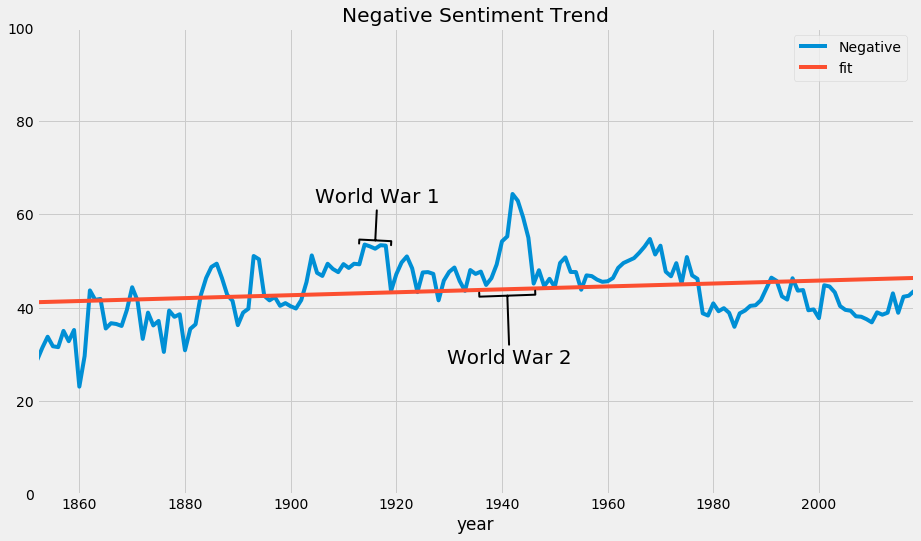

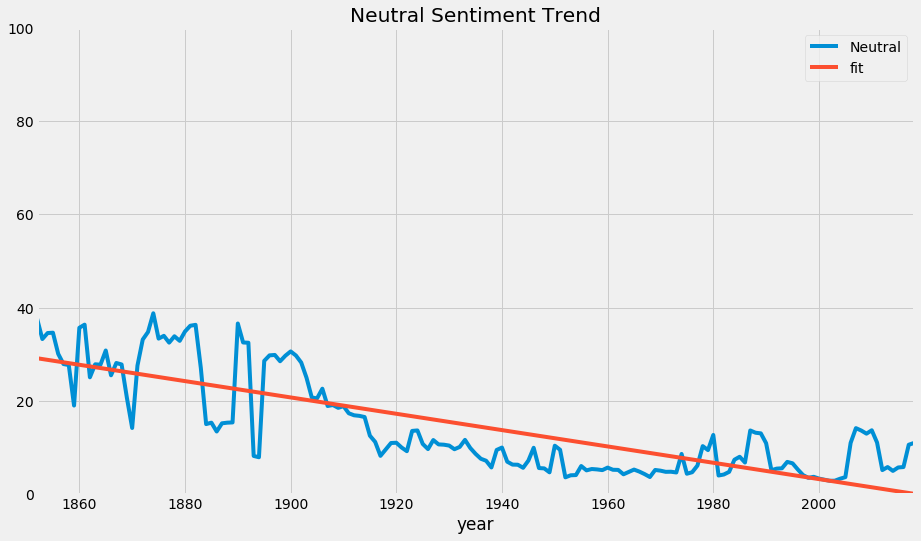

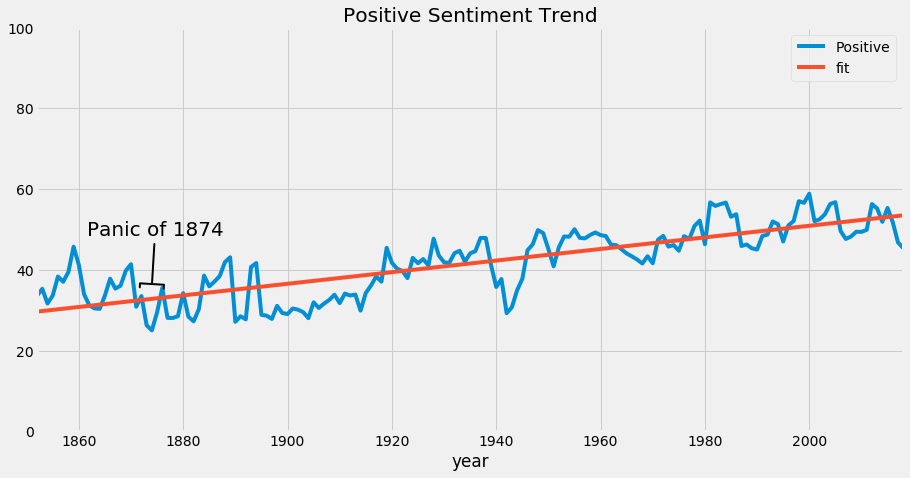

In [28]:
from matplotlib import pyplot
import statsmodels.api as sm

df['year'] = df.index.year
columns = ['Negative', 'Neutral', 'Positive']

with plt.style.context('fivethirtyeight'):
    for column in columns:
        fig, ax = pyplot.subplots(1,1)
        fig.set_size_inches(14, 8)
        df.plot(x='year', y=column, ax=ax)
        ax.set_title(label='{} Sentiment Trend'.format(column))
        ax.set_ylim(0,100)
        ax.margins(500)
        
        if column == 'Negative':
            ax.annotate('World War 2', 
                           xy=(1941,43), 
                           xytext=(-60,-70), textcoords='offset pixels',
                           size=20,
                           arrowprops=dict(arrowstyle='-[,widthB=1.4',
                                           lw=2,
                                           edgecolor='black',
                                           facecolor='black',
                                          )
                          )
            
            ax.annotate('World War 1', 
                           xy=(1916,54), 
                           xytext=(-60,40), textcoords='offset pixels',
                           size=20,
                           arrowprops=dict(arrowstyle='-[,widthB=0.8',
                                           lw=2,
                                           edgecolor='black',
                                           facecolor='black',
                                          )
                          )
            
        if column == 'Positive':
            ax.annotate('Panic of 1874', 
                           xy=(1874,36), 
                           xytext=(-65,50), textcoords='offset pixels',
                           size=20,
                           arrowprops=dict(arrowstyle='-[,widthB=0.6',
                                           lw=2,
                                           edgecolor='black',
                                           facecolor='black',
                                          )
                          )
        
        model = sm.formula.ols(formula='{} ~ year'.format(column), data=df)
        res = model.fit()
        df.assign(fit=res.fittedvalues).plot(x='year', y='fit', ax=ax)
    pyplot.tight_layout(pad=4)